In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import time
import json
import shutil
import pathlib
from pprint import pprint
from subprocess import check_output
from tqdm import tqdm

In [2]:
%%time

json_paths = sorted(pathlib.Path('../data/json').glob('*.json'))
large_json = pathlib.Path('../data/single.json')
with large_json.open('w') as fout:
    fout.write('[')
    for i, path in enumerate(tqdm(json_paths)):
        if i != 0:
            fout.write(',')
        with path.open('r') as fin:
            fout.write(fin.read())
    fout.write(']')

100%|██████████| 500000/500000 [03:24<00:00, 2439.45it/s]


CPU times: user 58.1 s, sys: 20 s, total: 1min 18s
Wall time: 3min 38s


In [7]:
!du -sh ../solr-7.3.0/

185M	../solr-7.3.0/


In [8]:
!../solr-7.3.0/bin/solr start

*** [WARN] *** Your open file limit is currently 1024.  
 It should be set to 65000 to avoid operational disruption. 
 If you no longer wish to see this warning, set SOLR_ULIMIT_CHECKS to false in your profile or solr.in.sh
*** [WARN] ***  Your Max Processes Limit is currently 31295. 
 It should be set to 65000 to avoid operational disruption. 
 If you no longer wish to see this warning, set SOLR_ULIMIT_CHECKS to false in your profile or solr.in.sh
Waiting up to 180 seconds to see Solr running on port 8983 [|] [/] [-] [\] [|] [/] [-] [\] [|] [/] [-] [\] [|] [/] [-] [\]  
Started Solr server on port 8983 (pid=22231). Happy searching!

  

In [9]:
!../solr-7.3.0/bin/solr create -c ettoday

         To turn off: bin/solr config -c ettoday -p 8983 -property update.autoCreateFields -value false

Created new core 'ettoday'


In [10]:
%%bash
curl 'http://localhost:8983/solr/ettoday/update?commit=true' \
    --data-binary @../data/single.json \
    -H 'Content-type:application/json'

{
  "responseHeader":{
    "status":0,
    "QTime":196646}}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1128M    0    60  100 1128M      0  5896k  0:03:16  0:03:16 --:--:--  114k


In [11]:
!du -sh ../solr-7.3.0/

1.8G	../solr-7.3.0/


In [12]:
# %%bash
# curl http://localhost:8983/solr/ettoday/query -d '
# {
#   "query" : "body:中文",
# }'

In [15]:
queries = np.load('../data/queries.npy')

cmd_fmt = 'curl -s http://localhost:8983/solr/ettoday/query -d "{}"'

def solr_query(q):
    cmd = cmd_fmt.format({
        'query': 'body:{}'.format(q)
    })
    res = json.loads(check_output(cmd, shell=True).decode('utf-8'))
    return res['responseHeader']['QTime']

df = pd.DataFrame(columns=['size', 'solr_time', 'solr_real_time'])
solr_time = 0
start_time = time.time()
for i, q in enumerate(tqdm(queries)):
    solr_time += solr_query(q)
    if (i + 1) % 1000 == 0:
        data = {
            'size': i + 1, 
            'solr_time': solr_time / 1000, 
            'solr_real_time': time.time() - start_time
        }
        df = df.append(data, ignore_index=True)

df.to_csv('../data/solr_df.csv', index=False)

100%|██████████| 100000/100000 [46:26<00:00, 35.88it/s]


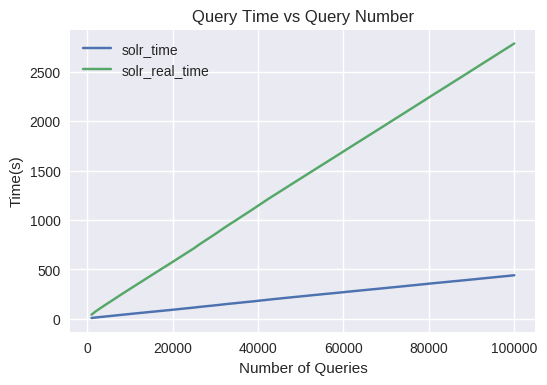

In [16]:
fig, ax = plt.subplots(dpi=100)
df.plot(ax=ax, x='size', y='solr_time')
df.plot(ax=ax, x='size', y='solr_real_time')
ax.set_ylabel('Time(s)')
ax.set_xlabel('Number of Queries')
ax.set_title('Query Time vs Query Number')
plt.show()

In [17]:
%%bash
# delete core
curl "http://localhost:8983/solr/admin/cores?action=UNLOAD&core=ettoday&deleteIndex=true&deleteDataDir=true&deleteInstanceDir=true"

{
  "responseHeader":{
    "status":0,
    "QTime":330}}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    57  100    57    0     0     57      0  0:00:01 --:--:--  0:00:01   168


In [18]:
!../solr-7.3.0/bin/solr stop -all

Sending stop command to Solr running on port 8983 ... waiting up to 180 seconds to allow Jetty process 22231 to stop gracefully.
 [|] [/] [-] [\]  